In [74]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://github.com/ClaudiuCreanga/hands-on-machine-learning-scikit-learn-tensorflow-oreilly-geron/tree/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [76]:
import pandas as pd


In [77]:
"""
    This function returns a pandas DataFrame object containing 
    all the data
"""
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [78]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [79]:
housing.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [80]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [81]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


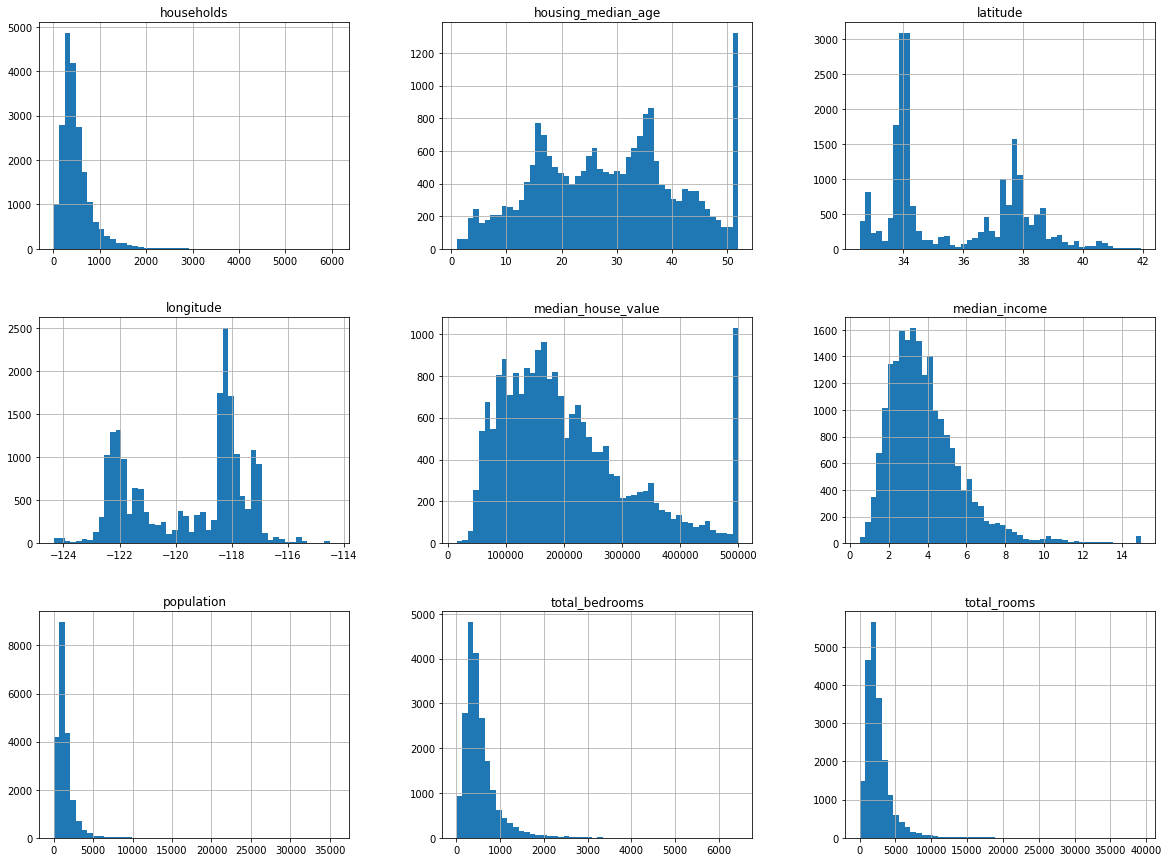

In [82]:
# firstly, we specify which backend Matplotlib should use
# the below command tells Jupyter to set up Matplotlib so it uses Jupyter's own backend'
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20, 15))
plt.show()

In [83]:
import numpy as np
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [84]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train + ", len(test_set), "test")


16512 train +  4128 test


In [93]:
import hashlib

"""
    Instead of picking random train & test data each time we run 
    the algorithm, we use the identifier of each instance to decide 
    whether or not it should go into the test set (on the assumption 
    of a unique and immutable identifier). 
    One way for this would be computing a hash of each instance's id, 
    and keep only the last byte of the hash, and put the instance in the
    test set if this value is lower or equal to 51 (~20% of 256). 
    
    As a result we ensure that the test set will remain consistent across 
    multiple runs, despite refreshing the dataset in the sense that
    new test set will contain 20% of instances, but no instance that was 
    previously in the training set; 
"""
def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id = housing.reset_index() # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

# Set an ID to the housing dataset, we use 
# a combination of latitude and longitude because (most likely) they will always be present; 
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [94]:
"""
    Scikit-Learn provides some functions for spliting datasets into multiple 
    subsets in various ways (chief usage reason?). 
    The split_train_test() lets you specify the random seed generator
"""
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)


In [95]:
"""
    Next we'll create categories for the median income (aka stratified sampling)
"""
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

In [96]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]


In [98]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [99]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)
    

In [101]:
########################################################################
##### Exploring and Visualizing the Data
########################################################################
# get a copy of it; in case too much data => get a sample of data
housing = strat_test_set.copy()

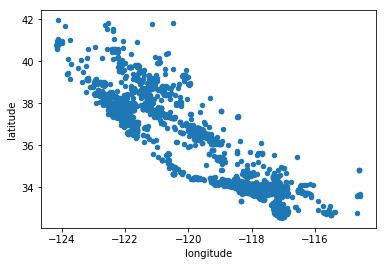

In [103]:
housing.plot(kind="scatter", x="longitude", y="latitude")

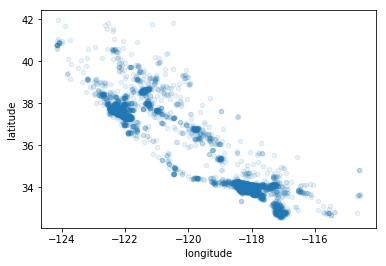

In [104]:
# To better view the data points with high density => alpha option = 0.1
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

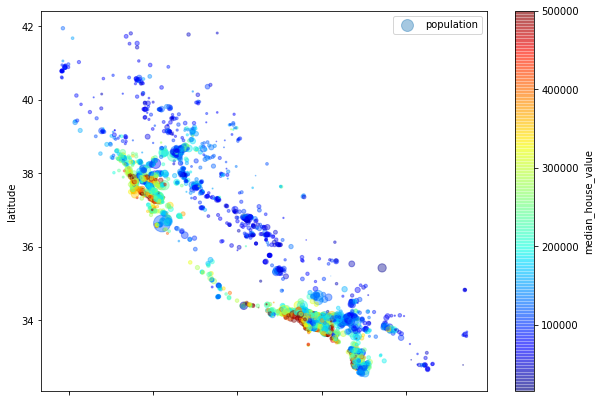

In [108]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
            s=housing["population"]/100, label="population",
            figsize=(10,7), c="median_house_value", cmap=plt.get_cmap("jet"),
            colorbar=True)
plt.legend()

In [109]:
corr_matrix=housing.corr()

In [110]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.691831
total_rooms           0.131435
housing_median_age    0.071357
households            0.071242
total_bedrooms        0.057568
population           -0.016033
longitude            -0.039987
latitude             -0.150124
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f580ae2af28>,
      dtype=object)

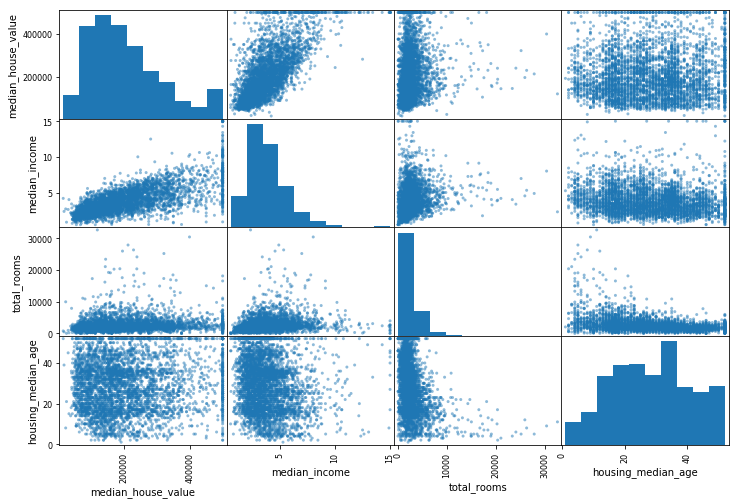

In [113]:
"""
    The correlation coefficient ranges from -1 to 1. When it is close to 1, 
    it means that there is a strong positive correlation; 
    for instance, the median house value tends to go up when the median
    income goes up;
    
    On the other hand, when the coefficient is close to -1, it means 
    a strong negative correlation exists; For instance geospatial
    features show a negative correlation with the aforementioned attributes; 
    
    Finally, coefficients close to zero, mean that there is no linear correlation;

    Pandas also provides the scatter_matrix() function, which plots every 
    numerical attribute against every other numerical attribute. 
    With 11 numerical attrs, we get 11^2 = 121 plots! 
    
    Hence, we focus on the attributes which are correlated as shown above;
"""
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", 
             "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))



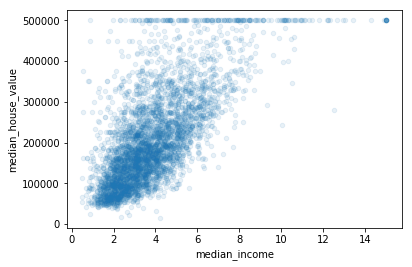

In [114]:
"""
    As we can see, the most promising attribute to predict the median house value
    is the median income, so let's zoom in on their correlation scatterplot
"""
housing.plot(kind="scatter", x="median_income", y="median_house_value",alpha=0.1)


In [117]:
"""
    The above scatterplot, shows quite a few things. First the upward trend 
    is pretty clear, and the points are not too dispersed. 
    Second, the price cap is visible as a horizontal line (kind of upperlimit)

    Now we play with combining attributes; 
    For example, the total number of rooms in a district is not very 
    useful if you don't know how many households there are; 
    
    What we want is the number of rooms per household! 
    Same applies for the total number of bedrooms, those we want to compare 
    to the number of rooms;
    
    And the population per household also seems like an interesting attribute
    combination to look at; 
"""
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]


In [118]:
# Again we check the correclation matrix
corr_matrix=housing.corr()

In [123]:
"""
    Below, the new attr bedrooms_per_room is much more correlated with the
    median house value than the total number of rooms or bedrooms. 
    Apparently, houses with a lower bedroom/room ratio tend to be more
    expensive (?). The number of rooms per household is also more 
    informative than the total number of rooms in a district - obviously the larger
    the houses, the more explensive they are!
    
    In the next section we take a look on data prep for ml algs.
"""
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.691831
rooms_per_household         0.192575
total_rooms                 0.131435
housing_median_age          0.071357
households                  0.071242
total_bedrooms              0.057568
population                 -0.016033
longitude                  -0.039987
population_per_household   -0.135142
latitude                   -0.150124
bedrooms_per_room          -0.240362
Name: median_house_value, dtype: float64

In [126]:

########################################################################
##### Preparing Data for ML Algorithms
########################################################################
"""
    This step should be handled in an automatic manner => write functions!
    
"""
# Let's get a new copy of training data
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()


In [129]:
"""
    Most ML algortihms cannot work WITH MISSING DATA, so we'll create
    a few functions to take care of them, by starting with total_bedrooms attribute.
    We have 3 alternatives:
    1. Get rid of the corresponding districts
    2. Get rid of the whole attribute
    3. Set the values to some value (zero, the mean, the median etc)
    
    Sure enough panda has functions exatcly for these cases
    dropna(), drop(), fillna()
"""
housing.dropna(subset=["total_bedrooms"]) # option 1
housing.drop("total_bedrooms", axis=1) # option 2
median = housing["total_bedrooms"].median() # option 3
# If opt 3 => compute the median value on the training set, and 
# use it to fill the missing values in the training set, but also
# don't forget to save the median value that you have computed!
# because you'll need it later to replace missing values in the test set
# when you want to evaluate your system, and also once the system goes live
# to replace missing values in new data
housing["total_bedrooms"].fillna(median, inplace=True)

"""
    Nevertheless, sckit provides a nice class to handle missing values: Imputer
    First we create an Imputer instance, specifying that you want to 
    replace each attribute's missing values with the median of that attribute
    
"""
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")
"""
    Since the median can only be computed on numerical attributes, we need to create
    a copy of the data without the text attribute ocean_proximity
"""
housing_num = housing.drop("ocean_proximity", axis=1)
# Now we can fit the imputer instance to the training data using the fit() method
imputer.fit(housing_num)
"""
    The imputer has simply computed the median of each attribute and stored the 
    result in its statistics_ instance variable; 
    Only the total_bedrooms attribute had missing values, but we cannot be sure 
    that there won't be any missing values in new data after the system goes live; 
    so it's safer to apply the imputer to all the numerical attributes
"""
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [130]:
# Now we can use this "trained" imputer to transorm the training set by replacing
# missing values by the learned medians (cute)
X = imputer.transform(housing_num)
# The result is a plain Numpy array containing the transformed features
# if you want to put it back into a Pandas DataFrame:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In [148]:
########################################################################
##### Feature Scaling
########################################################################
"""
    One of the most important transformations you need to apply to your 
    data is __feature scaling__. In general, ML alg dont perform well 
    when the input numerical attributes have very different scales.
    This is the case for the housing data: the total number
    of rooms ranges from about 6 to 39320, while the median incomes 
    only ranges from 0 to 15. Note that scaling the target values is 
    genrally not required. 
    
    The 2 most used ways to get all attributes to have the same scale are:
   
       1. min-max scaling (normalization)
       2. standardization
    
    Min-max scaling (aka normalization) is quite simple: values are
    shifted and rescaled so that they end up ranging from 0 to 1. 
    We do this by subtracting the min value and dividing by max value minus 
    the min value --- [ ( curr_val - min_val )/(max_val - min_val) ]
    Scikit-Learn provides a transformer called MinMaxScaler for this. 
    It has a feature_range hyperparameter that lets you change
    the range if you don't wan't 0-1 for some reason. 
    
    On the other hand standardization is quite different: first it subtracts
    the mean value (so standardized values always have a zero mean), 
    and then it divides by the variance so that the resulting distribution
    has unit variance. Unlike min-max scaling, standardization does not
    bound values to a specific range, which may be a problem for some
    algorithms, like neural networks that expect an input value ranging
    from 0 to 1. However, standardization is much less affected by 
    outliers (A);
    
    Its very important for all transformation to be applied only to the 
    training data, not the full dataset (including the test set). 
    Only then you can use them to transform the training set and test set(and new data)
    
    Next we take a look at Transformation Pipelines:
    We already see that there are many steps that need to be executed in 
    the right order. 
    Fortunately, Scikit-Learn provides the Pipeline class, to help with 
    such sequences of transformations. 
    Below we provide a small pipeline for the numerical attributes:
    
"""
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

"""
    The Pipeline constructor takes a list of name/estimator pairs
    defining a sequence of steps. All but the last estimator must 
    be transformers (i.e., they must have a fit_transform() method). 
    The names can be anything you like (as long as they dont contain
    double underscores "__")
    
    When the pipeline's fit() method gets called, it'll call 
    fit_transform() sequentially on all transformers, passing
    the output of each call as the parameter to the next call, 
    until it reaches the final estimator, 
    for which it just calls the fit() method. 
"""
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

num_pipeline = Pipeline([
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])
housing_num_tr = num_pipeline.fit_transform(housing_num)

"""
    Now we'll feed a Pandas DataFrame directly into our Pipeline, 
    instead of having to first manually extract the numerical columns
    into a NumPy array. There is nothing in Scikit-Learn to handle 
    Pandas DataFrames, but we'll write a custom transformer for this task
"""
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import preprocessing
from sklearn.base import TransformerMixin #gives fit_transform method for free

class MyLabelBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = preprocessing.LabelBinarizer(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        return self.encoder.transform(x)
    
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('label_binarizer',MyLabelBinarizer()),
    ])
    

In [151]:
"""
    To join the pipelines into one we use: 
    FeatureUnion from Scikit-Learn
"""
from sklearn.pipeline import FeatureUnion
full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [152]:
housing_prepared.shape

(16512, 16)

In [154]:
"""
   Until now we've done the following:
   
       1. Framed the problem
       2. Got the data and explored it
       3. Sampled a training set and a test set
       4. Wrote transformation pipelines to clean up and prepare the data for 
           ML algorithms automatically
           
    Next we select and train a Machine Learning model!
    
    First we train and evaluate on the training set
    
    We will first try Linear Regression model

"""
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

# And that's it! We now have a working linear regression model
# We'll try it out on a few instances from the training set

# * iloc : Integer-location based indexing for selection by position.
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions: ", lin_reg.predict(some_data_prepared))

Predictions:  [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [156]:
print("Labels: ", list(some_labels))

Labels:  [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [157]:
# Now we check the accuracy of the model using RMSE on the whole training
# set, using Scikit-Learn's mean_squared_error fn
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

In [159]:
# Not a very good score, since most districts' median_housing_values
# range between $120000 and $265000, so a typical prediction of 
# $686228 is not very amiable
# Furthermore, this is an example of a model underfitting the data
# when this happens it can mean that the features fo not provide
# enough information to make good predictions, or that the model 
# is not powerful enough. As we saw in the previous chapter, the main 
# ways to fix underfitting are to select a more powerful model ***** 
# , to feed the trainin algorithm with better features, or to reduce the constraints
# on the model. 
# Because the model is not regularized => the last option is ruled out
# We can try to add more features like the log of population. 
# But now we'll see what decision trees behaviour will be

from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

# Done with the training!
# Let's evaluate it on the training set
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [160]:
# Hmmmm ?? Could this be true?? No Error? Or maybe overfitting ??
# We'll check with cross validation
"""
    One way to test the DT model would be to use train_test_split
    function to split
    the training set into smaller training set and a validation set, then
    train your models against the smaller training set and evaluate them against
    the smaller training set. 
    We'll perform a K-fold cross validation: it randomly split the training set
    into 10 distinct subsets called folds, then it trains and evaluates the DT model
    10 times, picking a different fold for evaluation every time and training
    on the other 9 folds. The result is an array containing the 10 evaluation scores:
    
"""
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels ,
                        scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)



In [162]:
def display_res(scores):
    print('Scores:', scores)
    print('Mean', scores.mean())
    print('Standard Deviation', scores.std())

display_res(tree_rmse_scores)

Scores: [69380.70866099 67932.78898246 69701.42043878 70438.7772317
 70280.70184976 73916.29985282 71308.89312989 71088.77826151
 77346.81723461 69982.99004141]
Mean 71137.81756839145
Standard Deviation 2535.411611334918


In [163]:
# In short, it performs worse than linear regression
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,scoring="neg_mean_squared_error", cv=10)

In [164]:
lin_rmse_scores = np.sqrt(-lin_scores)

In [166]:
display_res(lin_rmse_scores)

Scores: [66761.51194567 66962.64795527 70349.92996432 74756.38194304
 68031.13388938 71193.84183426 64967.93464896 68262.2267385
 71529.15775812 67665.10082067]
Mean 69047.98674981864
Standard Deviation 2735.488028188857


In [168]:
# DT is overfitting => worse than LR
# We try RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

22216.853438888862

In [169]:
# Cross-validation:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_res(forest_rmse_scores)

Scores: [51488.50138502 50196.29340891 52191.79141133 54938.9413473
 53004.34657875 55451.23623295 51229.56989995 49950.24568553
 55304.85479268 53445.84211016]
Mean 52720.16228525843
Standard Deviation 1942.4246394638944


In [170]:
# Its definitely better (lower std)
# Still has overfitting issues on the training data set, although the 
# validation data set looks better
# Before delving into RF, many other ML models should be tested
# like SVM with different kernel sizes, possibly a neural network, etc), 
# without spending much time tweaking the hyperparameters

# Now, we can Fine-Tune the model :DD
# So after, we shortlisted the models, we get to fine-tune them
# How?
"""
    1. Grid Search ---> we use scikit, to try various possible
        combinations of hyperparameter values, using cross-validation
        
        For instance, below we search for the best combination
        of hyperparameter values for the RandomForestRegressor
"""
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, 
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features':[2,3,4]},
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [171]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [172]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)